<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Subreddit Classification

## Imports

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re

from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
import nltk

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, plot_roc_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Problem Statement

We are a hypothetical team of Data Scientist working for the American video live streaming company, Twitch. Twitch currently has a forum for twitch viewers to come together and discuss their favourite topics under thread titles like Video Games, Youtubers, or Music. In an effort to improve and expand its forum sectio, Twitch is looking to create sub threads for specific respective game titles like Dota2, Valorant, or League of Legends. Our team are, therefore, engaged to categorise each existing comments in the VideoGames thread and place them into their respective sub-threads of Dota2 and LoL (League of Legends).

To achieve this, 4000 posts and comments are pulled from each of the Leagueoflegends and dota2 subreddits for analysis, and to work as basis for our machine learning model building. The machine learning models will be taught key differentiator of the two video games, and hence be tasked to categorise comments of the respective video games on the Twitch Forum.

### Contents:
- Background
- Data Extraction with PushShift API
- Data Cleaning and EDA
- Model and Test
- Conclusions and Recommendations

## Background

<p style="color:Navy;">TWITCH</p>
Twitch is a video live streaming service based in the United States that centers around video game live streaming, including esports tournament broadcasts, as well as music broadcasts, creative content, and "in real life" feeds. Twitch Interactive, an Amazon.com, Inc. subsidiary, runs it. It debuted in June 2011 as a spin-off of Justin.tv, a general-interest streaming network. The site's content can be accessed in real time or on demand.

<p style="color:Navy;">DOTA2</p>
Valve created and distributed Dota 2, a multiplayer online battle arena (MOBA) computer game. Defense of the Ancients (DotA), a community-created mod for Blizzard Entertainment's Warcraft III: Reign of Chaos, is the game's sequel. Dota 2 is a game in which two teams of five players compete against each other, each defending and occupying their own base on the map. Each of the ten players takes control of a powerful figure known as a "hero," who all have different powers and play styles. In player vs player combat, players gather experience points and gear for their characters in order to beat the enemy team's heroes. A team wins if they are the first to destroy the opposing team's base.

<p style="color:Navy;">LEAGUE OF LEGENDS</p>
On another hand, League of Legends (LoL), sometimes known as League, is similarly a multiplayer online battle arena video game created and distributed by Riot Games in 2009. Riot's founders were inspired by Defense of the Ancients, a custom map for Warcraft III, to create a standalone game in the same genre. League has been free-to-play since its launch in October 2009, with character customization available for purchase.





## Data Import and Cleaning

In [9]:
df_lol = pd.read_csv('lol.csv')
df_dota = pd.read_csv('dota.csv')

In [10]:
def remove_dropped_posts(df_posts):
    df_posts = df_posts[df_posts['removed_by_category'].isna()]

    return df_posts

df_lol = remove_dropped_posts(df_lol)
df_dota = remove_dropped_posts(df_dota)

### Dealing with Nan values

In [11]:
df_lol['title'].isnull().sum()
df_dota['title'].isnull().sum()

0

In [12]:
df_lol['selftext'].isnull().sum()
df_dota['selftext'].isnull().sum()

1567

In [13]:
df_lol['selftext'] = df_lol['selftext'].fillna('')
df_dota['selftext'] = df_dota['selftext'].fillna('')

<font color='navy'>As removing rolls containing nan values may also remove precious data for the mdoel, nan values are filled with blanks</font>

In [14]:
df_lol['selftext'].isnull().sum()
df_dota['selftext'].isnull().sum()

0

In [15]:
df_dota_lol = pd.concat([df_lol, df_dota], axis=0)
df_dota_lol['subreddit'].value_counts(normalize=True)

DotA2              0.5868
leagueoflegends    0.4132
Name: subreddit, dtype: float64

<font color='navy'>Data of dotA2 is 58% as compared to that of leagueoflegends as 41% - Might requires Smoting</font>

In [16]:
df_dota_lol['title_selftext'] = df_dota_lol['title'] + ' ' + df_dota_lol['selftext']
df_dota_lol = df_dota_lol[['title_selftext', 'subreddit']]

### Removing Website Links 

In [17]:
df_dota_lol['title_selftext'] = df_dota_lol['title_selftext'].apply(lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x))
df_dota_lol['title_selftext']

2       How to acquire all Teamwork and Strategy chall...
3       Is Zeri balanced around a feature that was nev...
4       Challenges are here! I love how the client nev...
5       does riot care about thier client?? this fucki...
6       ARURF Account Setting Tutorial If you prefer t...
                              ...                        
3995       Quincy Crew parts ways with Ponlo &amp; Milan 
3996                                  HellRaisers update 
3997                           Test Dont mind me test lol
3998    hi i cant download my replay what should i do ...
3999                                             meme :) 
Name: title_selftext, Length: 5818, dtype: object

### Removing Punctuations

In [18]:
def remove_punct(text):
    # store character only if it is not a punctuation
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

df_dota_lol['title_selftext_clean'] = df_dota_lol['title_selftext'].apply(lambda x: remove_punct(x))
df_dota_lol['title_selftext_clean']

2       How to acquire all Teamwork and Strategy chall...
3       Is Zeri balanced around a feature that was nev...
4       Challenges are here I love how the client neve...
5       does riot care about thier client this fuckign...
6       ARURF Account Setting Tutorial If you prefer t...
                              ...                        
3995         Quincy Crew parts ways with Ponlo amp Milan 
3996                                  HellRaisers update 
3997                           Test Dont mind me test lol
3998    hi i cant download my replay what should i do ...
3999                                               meme  
Name: title_selftext_clean, Length: 5818, dtype: object

### Tokenizing Data

In [19]:
tokenizer = RegexpTokenizer(r'[^\d\W]{2,}') 

df_dota_lol['title_selftext_tokens'] = df_dota_lol['title_selftext_clean'].apply(lambda x: tokenizer.tokenize(x.lower()))
df_dota_lol.loc[:, 'tokens_len'] = df_dota_lol.loc[:, 'title_selftext_tokens'].apply(lambda x: len(set(x)))
df_dota_lol['title_selftext_tokens']

2       [how, to, acquire, all, teamwork, and, strateg...
3       [is, zeri, balanced, around, feature, that, wa...
4       [challenges, are, here, love, how, the, client...
5       [does, riot, care, about, thier, client, this,...
6       [arurf, account, setting, tutorial, if, you, p...
                              ...                        
3995    [quincy, crew, parts, ways, with, ponlo, amp, ...
3996                                [hellraisers, update]
3997                    [test, dont, mind, me, test, lol]
3998    [hi, cant, download, my, replay, what, should,...
3999                                               [meme]
Name: title_selftext_tokens, Length: 5818, dtype: object

### Histogram Plot (Exploring Distribution)

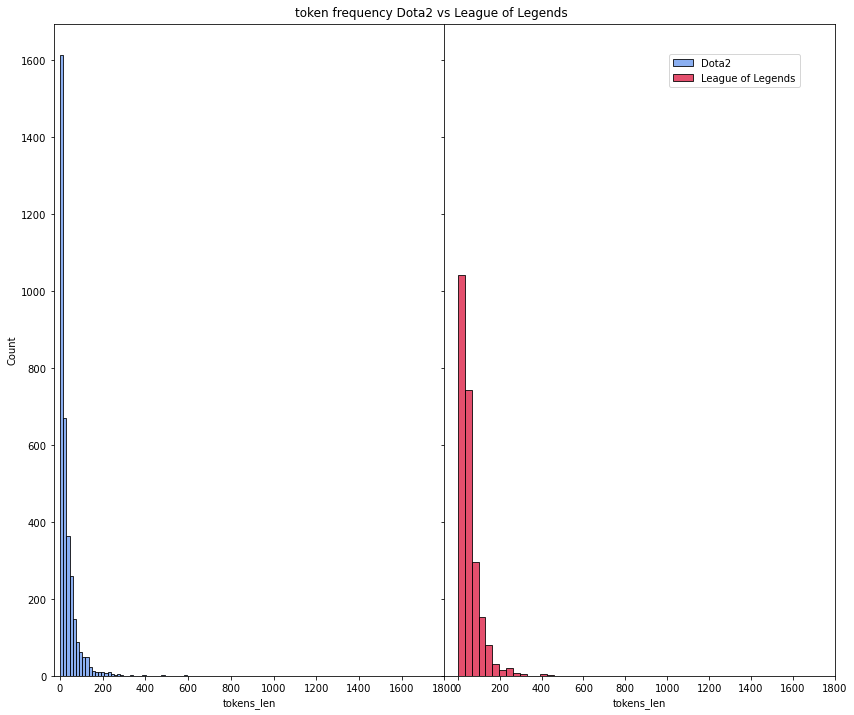

In [20]:
def hist_sub_plot(dataset1, dataset2, label1="", label2="", bins_count=0, title=""):
    fig, ax = plt.subplots(1, 2, figsize=(14, 12), sharey=True)
    fig.suptitle(title, y=0.9)
    
    if(bins_count == 0):
        sp1 = sns.histplot(dataset1, ax=ax[0], color="cornflowerblue")
        sp2 = sns.histplot(dataset2, ax=ax[1], color="crimson")
    else:
        sp1 = sns.histplot(dataset1, ax=ax[0], color="cornflowerblue", bins=bins_count)
        sp2 = sns.histplot(dataset2, ax=ax[1], color="crimson", bins=bins_count)
        
    plt.subplots_adjust(wspace=0)
    
    if(label1 != "" and label2 != ""):
        fig.legend(labels=[label1,label2], bbox_to_anchor=(0.87,0.85))
    
    return sp1, sp2

hist1, hist2 = hist_sub_plot(df_dota_lol[df_dota_lol['subreddit']=='DotA2']['tokens_len'], 
              df_dota_lol[df_dota_lol['subreddit']=='leagueoflegends']['tokens_len'],
             label1='Dota2', label2='League of Legends', bins_count=40, title="token frequency Dota2 vs League of Legends");

hist1.set_xticks(range(0,2000, 200));
hist2.set_xticks(range(0,2000, 200));

<font color='navy'>Both Data are right-skewed - fix by dealing with outliers</font>

### Histogram Plot (Exploring Distribution)

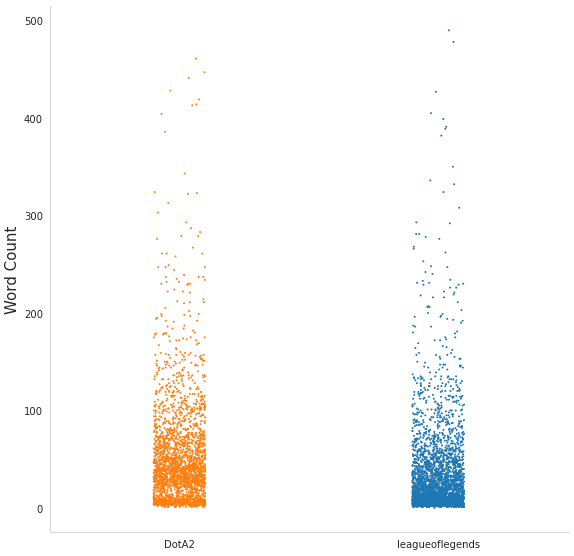

In [21]:
### Histogram Plot (Exploring Distribution)sns.set(font_scale = 2)
sns.set_style("whitegrid", {'axes.grid' : False})

cp = sns.catplot(x="subreddit", y="tokens_len", 
            kind="strip", 
            data=df_dota_lol[df_dota_lol['tokens_len'] < 500].sort_values(by='subreddit', ascending=False), 
            height=8, s=2, palette=["C1","C0"])

plt.xlabel('', fontsize=15)
plt.ylabel('Word Count', fontsize=15)
cp.set_xticklabels(['DotA2', 'leagueoflegends'])

sns.reset_orig() 

In [22]:
df_dota_lol[df_dota_lol['tokens_len'] > 500]['title_selftext'].apply(print)

Damage, Items, and the Evolution of a Game: A Thesis on the Design Philosophy of Modern League Hey y'all, it's your boy tormentedlol here, once again posting a 5 year long essay on the game. There's a tl;dr at the bottom if you don't wanna read a whole article. Just wanted to post some thoughts I had on the game before Patch 12.10 hits. Ultimately, the point of this post is to invite a discussion on the game.

**Introduction:**  
When mentioning the words *League of Legends* to any online gaming enthusiast, the response received is often a mixture of exasperation, revile, and appreciation, mixed with a healthy dose of nostalgia. It is the game that you visit this subreddit for, it is a game millions of people have sunk hundreds to thousands of hours into, and it is a game that has endured for almost a decade and a half from Alpha to the upcoming Durability Patch. It is also a game that houses contentious back and forths amongst many of its supporters and haters over both the minutiae a

242     None
263     None
378     None
605     None
703     None
1271    None
3427    None
1409    None
1538    None
Name: title_selftext, dtype: object

<font color='navy'>Outliers gives very good information and includes a lot of good keywords - Do not remove outliers <font>

### Removing StopWords

In [23]:
nltk.download('stopwords')
stop_words = stopwords.words("english")

def remove_stop_words(w_list, stop_word_list):
    no_stop_list = [token for token in w_list if token not in stop_word_list]
    return no_stop_list

df_dota_lol.loc[:, 'tokens_no_sw'] = df_dota_lol['title_selftext_tokens'].apply(remove_stop_words, args=([stopwords.words('english')]))

#addition stopwords that happens very frequently in data
stopwords_list = ['since','game','gt','even','people','know','dont','match','playing','im','would','one','time','bo',
                  'get','player','team','game','damage','guy','something','year','every','please','see','much',
                  'good','really',' back','cant','win','it','got','account','still','want','think','also','support',
                  'make','item','day','win','first','year','enemy','thing','day','feel','could','top','every','go','got',
                  'damage','see','also','skin','good','playing','ampx','make','know','people','even','get', 'need', 'played', 
                  'way', 'anyone', 'back', 'it', 'new', 'players', 'game', 'play', 'like', 'lane', 'group', 'server', 'change',
                  'fix','guide','id','guy','last','patch','bug','lp','video','level','ive','someone','chat','skin','ranked',
                  'games', 'getting', 'going', 'say', 'getting', 'help', 'mid', 'rank', 'never', 'give', 'best', 'guy', 'player', 
                  'game', 'issue', 'client', 'post', 'getting', 'skins', 'game', 'guess', 'update', 'po', 'guys', 'bad', 'stage', 'else',
                  'player','teams','fun','find','carry','guy','game','screen','right','doesnt','friend', 'work', 'made', 'main', 'point', 
                  'love', 'year', 'reason', 'high', 'many', 'better', 'ever', 'come', 'years', 'today', 'thought', 'next', 'kills', 'sea',
                  'anything','everyone', 'na', 'kill', 'take', 'pro', 'report', 'second', 'idea', 'banned', 'pick', 'end', 'lot', 'well', 
                  'look', 'looking', 'problem', 'looking', 'didnt', 'start', 'literally', 'eg', 'title', 'maybe', 'month', 'hard', 'use',
                  'question', 'weeks', 'always', 'two', 'around', 'week', 'twitch', 'already', 'bot', 'queue', 'watch', 'trying', 'og',
                  'role', 'clash', 'true', 'ban', 'actually', 'tell', 'show', 'event', 'skill', 'without', 'able', 'let', 'sure',
                  'score', 'pas', 'try', 'ago','min', 'old', 'ward', 'different', 'pretty', 'mean', 'hope', 'pentakill', 'minute', 'season',
                  'reward', 'battle', 'jungle', 'thanks', 'keep'] 

[nltk_data] Downloading package stopwords to C:\Users\get gd
[nltk_data]     nub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lemmatizing Data

In [24]:
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

def lemmatize_list(w_list):
    lem_word = []
    for word in w_list:
        lem_word.append(lemmatizer.lemmatize(word))
    return lem_word

df_dota_lol.loc[:, 'tokens_lem'] = df_dota_lol['tokens_no_sw'].apply(lemmatize_list)
df_dota_lol.loc[:, 'tokens_lem'] = df_dota_lol['tokens_lem'].apply(remove_stop_words, args=([stopwords_list]))
df_dota_lol['tokens_lem']

[nltk_data] Downloading package wordnet to C:\Users\get gd
[nltk_data]     nub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\get gd
[nltk_data]     nub\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


2       [acquire, teamwork, strategy, challenge, leagu...
3       [zeri, balanced, feature, intended, may, zeri,...
4       [challenge, fails, remind, feature, added, ope...
5       [riot, care, thier, fuckign, bugged, tf, monke...
6       [arurf, setting, tutorial, prefer, urf, bp, mo...
                              ...                        
3995              [quincy, crew, part, ponlo, amp, milan]
3996                                        [hellraisers]
3997                              [test, mind, test, lol]
3998         [hi, download, replay, hi, download, replay]
3999                                               [meme]
Name: tokens_lem, Length: 5818, dtype: object

### Stemming Data

In [25]:
p_stemmer = PorterStemmer()

def stem_list(w_list):
    st_word = []
    for word in w_list:
        st_word.append(p_stemmer.stem(word))
    return st_word

df_dota_lol.loc[:, 'tokens_stem'] = df_dota_lol['tokens_no_sw'].apply(stem_list)
df_dota_lol.loc[:, 'tokens_stem']

2       [acquir, teamwork, strategi, challeng, titl, l...
3       [zeri, balanc, around, featur, never, intend, ...
4       [challeng, love, client, never, fail, remind, ...
5       [riot, care, thier, client, fuckign, client, b...
6       [arurf, account, set, tutori, prefer, old, urf...
                              ...                        
3995         [quinci, crew, part, way, ponlo, amp, milan]
3996                                    [hellrais, updat]
3997                        [test, dont, mind, test, lol]
3998    [hi, cant, download, replay, guy, hi, cant, do...
3999                                               [meme]
Name: tokens_stem, Length: 5818, dtype: object

### Sentence Forming with Processed Tokens

In [26]:
df_dota_lol.loc[:, 'title_selftext_lem_sen'] = df_dota_lol['tokens_lem'].apply(lambda x: ' '.join(map(str, x)))
df_dota_lol.loc[:, 'title_selftext_stem_sen'] = df_dota_lol['tokens_stem'].apply(lambda x: ' '.join(map(str, x)))
df_dota_lol = df_dota_lol.fillna('')
df_dota_lol.loc[:, 'title_selftext_lem_sen']

2       acquire teamwork strategy challenge league legend
3       zeri balanced feature intended may zeri suffer...
4       challenge fails remind feature added open some...
5       riot care thier fuckign bugged tf monkey offic...
6       arurf setting tutorial prefer urf bp mode arur...
                              ...                        
3995                     quincy crew part ponlo amp milan
3996                                          hellraisers
3997                                   test mind test lol
3998                hi download replay hi download replay
3999                                                 meme
Name: title_selftext_lem_sen, Length: 5818, dtype: object

### Visualising Most Frequent Words

In [27]:
def plot_barcharts(df_coef1, df_coef2, title=""):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(title, y=0.93)

    plot1 = df_coef1.plot(kind='barh', y='value', x='feature_name', 
                                                                     ax=axes[0], figsize=(12,10), label='_', 
                                                                       fontsize=12, color='salmon');
    plot1.set_xlabel('Count', fontsize=12)
    plot1.set_ylabel('Words', fontsize=12)
    plot1.set_title('Dota 2')
    
    plot2 = df_coef2.plot(kind='barh', y='value', 
                                                                  x='feature_name', fontsize=12,
                                                             ax=axes[1], figsize=(12,10),label='_', 
                                                                        color='skyblue');

    plot2.set_xlabel('Count', fontsize=12)
    plot2.set_ylabel('Words', fontsize=12)
    plot2.set_title('league of legends')

    plt.subplots_adjust(wspace=0.8)
    plt.show()

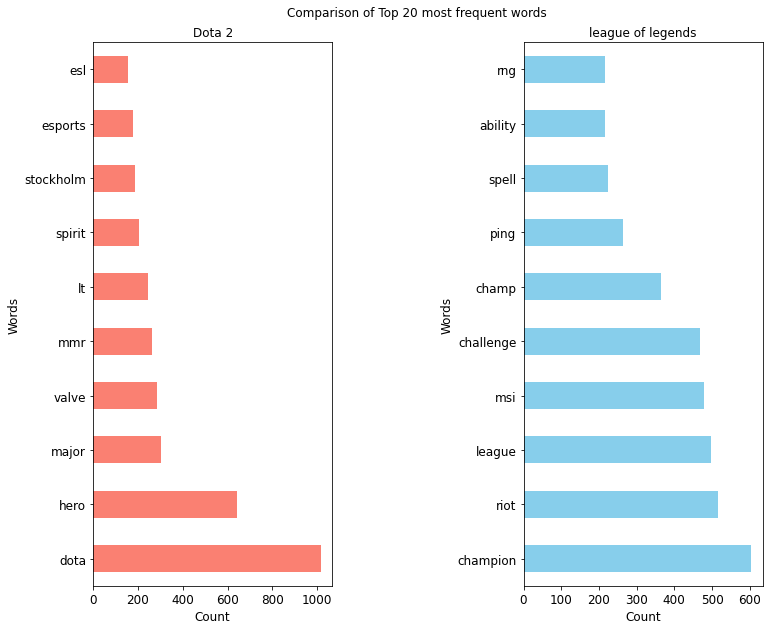

In [28]:
#Count Vectorizing Lemmatized Tokens(1 ngram)
cvec1 = CountVectorizer(ngram_range=(1,1))

df_dota_cvec_lem1 = pd.DataFrame(cvec1.fit_transform(df_dota_lol[df_dota_lol['subreddit'] == 'DotA2']['title_selftext_lem_sen']).todense(), columns=cvec1.get_feature_names())

df_lol_cvec_lem1 = pd.DataFrame(cvec1.fit_transform(df_dota_lol[df_dota_lol['subreddit'] == 'leagueoflegends']['title_selftext_lem_sen']).todense(), columns=cvec1.get_feature_names())

plot_barcharts(df_dota_cvec_lem1.sum().sort_values(ascending=False).head(10), df_lol_cvec_lem1.sum().sort_values(ascending=False).head(10), "Comparison of Top 20 most frequent words")

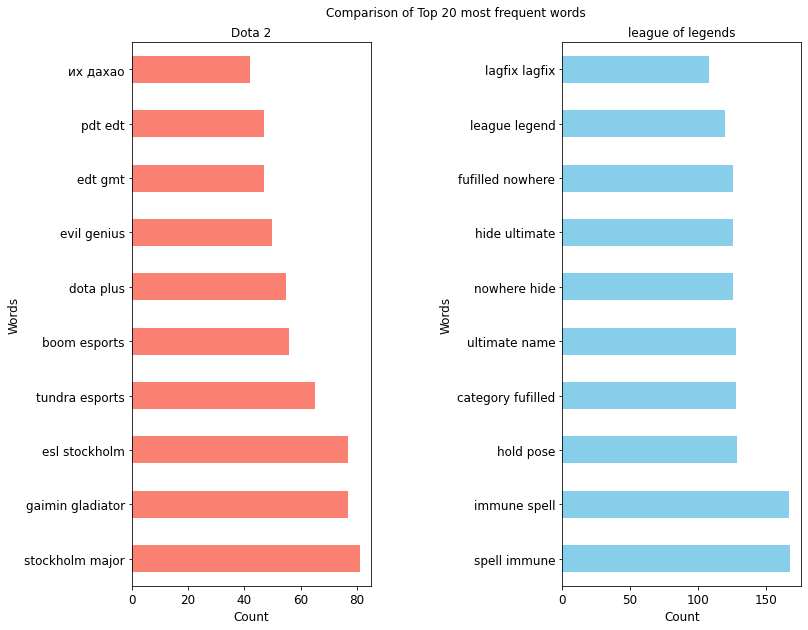

In [29]:
#Count Vectorizing Lemmatized Tokens (2 ngram)
cvec1 = CountVectorizer(ngram_range=(2,2))

df_dota_cvec_lem2 = pd.DataFrame(cvec1.fit_transform(df_dota_lol[df_dota_lol['subreddit'] == 'DotA2']['title_selftext_lem_sen']).todense(), columns=cvec1.get_feature_names())

df_lol_cvec_lem2 = pd.DataFrame(cvec1.fit_transform(df_dota_lol[df_dota_lol['subreddit'] == 'leagueoflegends']['title_selftext_lem_sen']).todense(), columns=cvec1.get_feature_names())

plot_barcharts(df_dota_cvec_lem2.sum().sort_values(ascending=False).head(10), df_lol_cvec_lem2.sum().sort_values(ascending=False).head(10), "Comparison of Top 20 most frequent words")


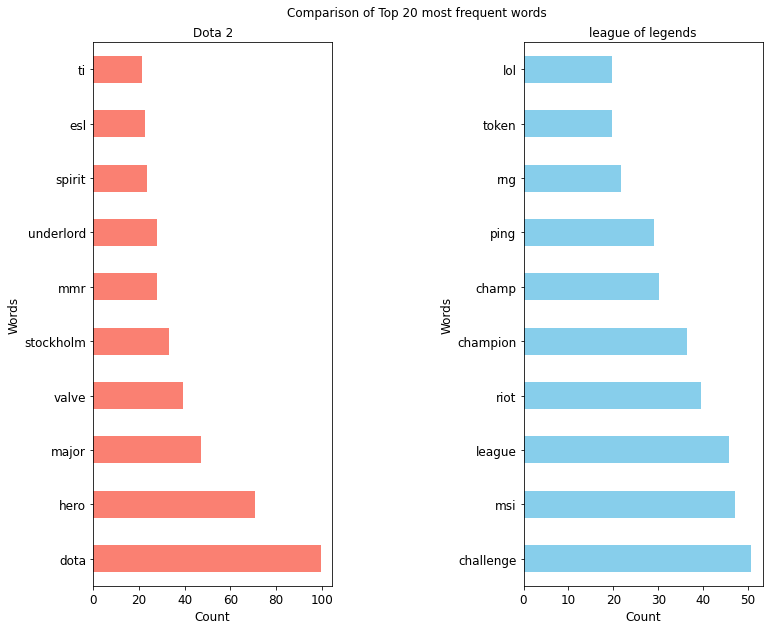

In [30]:
#TF-IDF Vectorizing Lemmatized Tokens(1 ngram)
tvec1 = TfidfVectorizer(ngram_range=(1,1))

df_dota_tfidf_lem1 = pd.DataFrame(tvec1.fit_transform(df_dota_lol[df_dota_lol['subreddit'] == 'DotA2']['title_selftext_lem_sen']).todense(), columns=tvec1.get_feature_names())

df_lol_tfidf_lem1 = pd.DataFrame(tvec1.fit_transform(df_dota_lol[df_dota_lol['subreddit'] == 'leagueoflegends']['title_selftext_lem_sen']).todense(), columns=tvec1.get_feature_names())

plot_barcharts(df_dota_tfidf_lem1.sum().sort_values(ascending=False).head(10), df_lol_tfidf_lem1.sum().sort_values(ascending=False).head(10), "Comparison of Top 20 most frequent words")

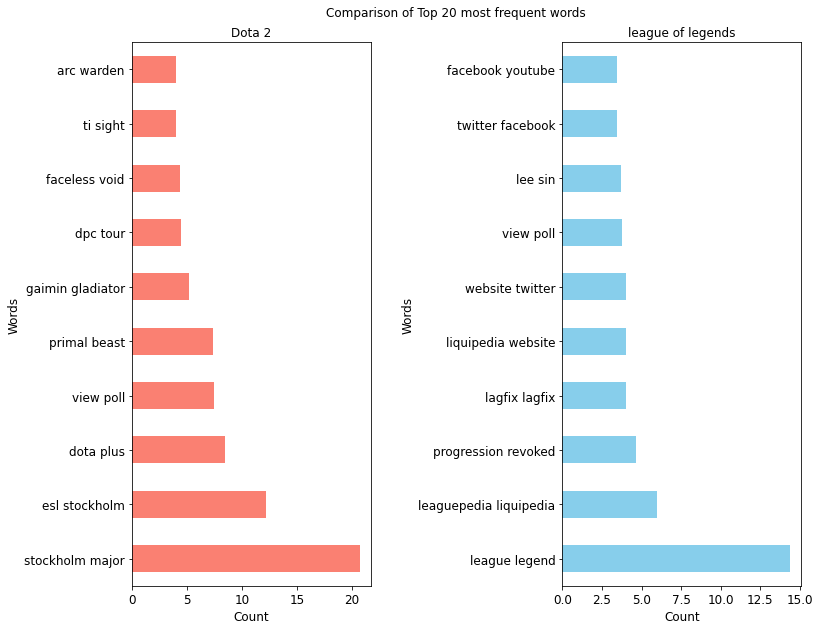

In [31]:
#TF-IDF Vectorizing Lemmatized Tokens (2 ngram)
tvec1 = TfidfVectorizer(ngram_range=(2,2))

df_dota_tfidf_lem2 = pd.DataFrame(tvec1.fit_transform(df_dota_lol[df_dota_lol['subreddit'] == 'DotA2']['title_selftext_lem_sen']).todense(), columns=tvec1.get_feature_names())

df_lol_tfidf_lem2 = pd.DataFrame(tvec1.fit_transform(df_dota_lol[df_dota_lol['subreddit'] == 'leagueoflegends']['title_selftext_lem_sen']).todense(), columns=tvec1.get_feature_names())

plot_barcharts(df_dota_tfidf_lem2.sum().sort_values(ascending=False).head(10), df_lol_tfidf_lem2.sum().sort_values(ascending=False).head(10), "Comparison of Top 20 most frequent words")

## Model Testing

In [32]:
df_dota_lol.head()

X = df_dota_lol['title_selftext_lem_sen']
y = df_dota_lol['subreddit'].map({'leagueoflegends':0, 'DotA2':1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

In [50]:
def plot_roc_auc_curve(model, X_test_values, y_test_values):
    
    y_pred_proba = model.predict_proba(X_test_values)[:,1]
    fpr, tpr, _ = roc_curve(y_test_values,  y_pred_proba)
    auc = roc_auc_score(y_test_values, y_pred_proba)
    
    plt.plot(fpr,tpr,label="data, auc=" + str(round(auc,4)))
    plt.title("ROC Curve")
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.plot(["0", "1"], ["0", "1"], label='baseline', linestyle='--')
    plt.legend(loc=4)
    plt.show()
    
    return auc

def analyse_model_performance(model, X_train_values, y_train_values, X_test_values, y_test_values):
    
    
    # Get predictions
    preds = model.predict(X_test_values)

    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test_values, preds).ravel()

    dict_scores = {'model': str(model.estimator.steps),
                   'cross_val_score': model.best_score_, 
                   'train_auc_score': model.score(X_train_values, y_train_values),
                   'test_auc_score': model.score(X_test_values, y_test_values),
                   'train_accuracy_score': accuracy_score(y_train_values, model.predict(X_train_values)),
                   'test_accuracy_score': accuracy_score(y_test_values, model.predict(X_test_values)),               
                   'sensitivity': tp / (tp + fn),
                   'specificity': tn / (tn + fp)}

    print(f"optimal Parameters: \n{model.best_params_}\n")
    print(f"Cross Validation Score: \n{dict_scores['cross_val_score']}\n")
    print(f"Train AUC Score: \n{dict_scores['train_auc_score']}\n")
    print(f"Test AUC SCore: \n{dict_scores['test_auc_score']}\n")
    print(f"Train Accuracy Score: \n{dict_scores['train_accuracy_score']}\n")
    print(f"Test Accuracy Score: \n{dict_scores['test_accuracy_score']}\n")
    print(f"Sensitivity: \n{dict_scores['sensitivity']}\n")    
    print(f"Specificity: \n{dict_scores['specificity']}\n")

    plt.figure(figsize=(9,9));
    cf = plot_confusion_matrix(model, X_test_values, y_test_values, display_labels=['DotA2', 'leagueoflegends'], cmap='Blues', values_format='d');
    plt.show();
    
    plt.figure(figsize=(6,6));
    auc = plot_roc_auc_curve(model, X_test, y_test);
    plt.show();
    
    return dict_scores

# Get most important words based on coefficients of the logistic regression model
def get_important_features_lr(vectoriser, estimator, n):
    feature_names = pd.DataFrame(vectoriser.get_feature_names(), columns=['feature_name'])    
    
    df_coef = pd.DataFrame(estimator.coef_)
    df_coef = df_coef.T
    
    df_coef = pd.concat([df_coef, feature_names], axis=1)    
    df_coef = df_coef.rename(columns={0:'value'})    
        
    return df_coef.sort_values(by='value', ascending=True)[:20], df_coef.sort_values(by='value', ascending=False)[:20]

# plot most important words passed in the two datasets
def plot_important_words(df_coef1, df_coef2, title=""):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(title, y=0.93)

    plot1 = df_coef1.sort_values(by='value', ascending=False)[:20].plot(kind='barh', y='value', x='feature_name', 
                                                                     ax=axes[0], figsize=(12,10), label='_', 
                                                                       fontsize=12, color='salmon');
    plot1.set_xlabel('Importance', fontsize=12)
    plot1.set_ylabel('Words', fontsize=12)
    plot1.set_title('DotA2')
    
    plot2 = df_coef2.sort_values(by='value', ascending=True)[:20].plot(kind='barh', y='value', 
                                                                  x='feature_name', fontsize=12,
                                                             ax=axes[1], figsize=(12,10),label='_', 
                                                                        color='skyblue');

    plot2.set_xlabel('Importance', fontsize=12)
    plot2.set_ylabel('Words', fontsize=12)
    plot2.set_title('leagueoflegends')

    plt.subplots_adjust(wspace=0.8)
    plt.show()

#Get feature importances for NB

def get_feature_importance_NB(estimator, transformer, ascending=True):
    
    delta_log_prob = estimator.feature_log_prob_[1,:] - estimator.feature_log_prob_[0,:]
    words = transformer.get_feature_names_out()
    df = df_pd.DataFrame({'feature': words, 'log_prob_difference': delta_log_prob})
    df.sort_values(by=['log_prob_difference'], inplace = True, ascending=ascending)
    
    return df

### Logistic Regression (Count Vector)

optimal Parameters: 
{'cvec__max_df': 0.85, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'lr__C': 0.1151395399326447, 'lr__penalty': 'l2', 'lr__random_state': 123, 'lr__solver': 'liblinear'}

Cross Validation Score: 
0.9565590954506314

Train AUC Score: 
0.9920037297108678

Test AUC SCore: 
0.9654592199181353

Train Accuracy Score: 
0.9167485265225933

Test Accuracy Score: 
0.870561282932417

Sensitivity: 
0.9765853658536585

Specificity: 
0.7198335644937587



<Figure size 648x648 with 0 Axes>

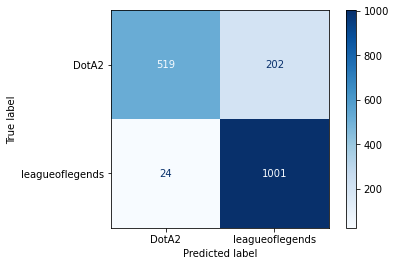

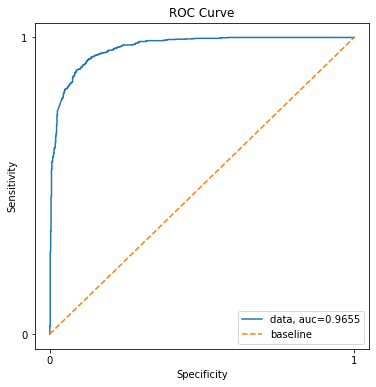

In [34]:
pipe = Pipeline([('cvec', CountVectorizer()),('lr', LogisticRegression())])

#Setting Pipe Parameters
pp = { 'cvec__max_features': [4_000],
                'cvec__min_df': [2],
                'cvec__max_df': [.85, .9],
                'cvec__ngram_range': [(1,1), (1,2)],
                'lr__C': np.logspace(-2, 2, 50),
                'lr__solver': ['liblinear'],
                'lr__random_state': [123],
                'lr__penalty': ['l1','l2']}

scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

#gridsearchcv
gs = GridSearchCV(pipe, param_grid=pp, cv=5, scoring=scoring, refit='AUC')

#results
gs.fit(X_train, y_train)
score_dict = {}
score_dict = analyse_model_performance(gs, X_train, y_train, X_test, y_test)
score_dict['model'] ="CountVec + Logistic Regression"
scores = []
scores.append(score_dict)

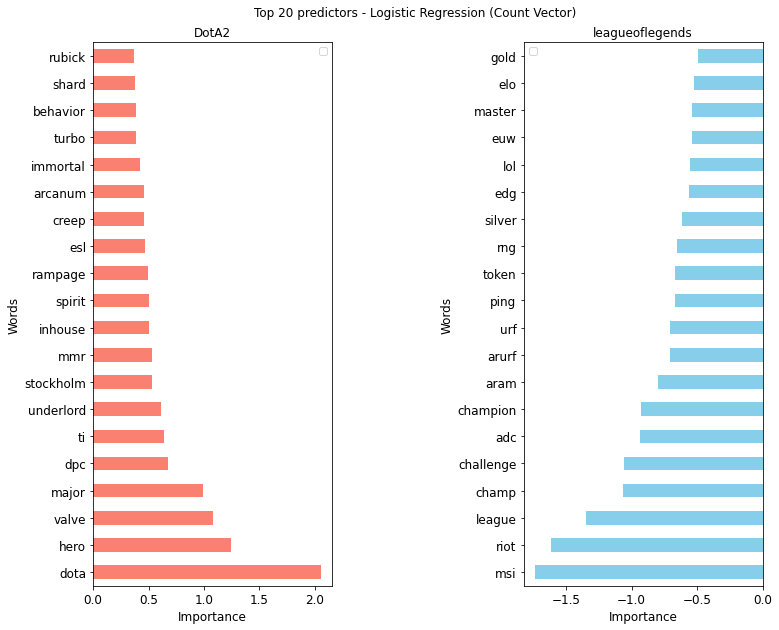

In [35]:
#Top 20 predictors
df_dota_cor, df_lol_cor = get_important_features_lr(gs.best_estimator_.named_steps.cvec, gs.best_estimator_.named_steps.lr, 10)
plot_important_words(df_lol_cor, df_dota_cor, title="Top 20 predictors - Logistic Regression (Count Vector) ")

### Logistic Regression (TFIDF)

optimal Parameters: 
{'lr__C': 0.7543120063354615, 'lr__penalty': 'l2', 'lr__random_state': 123, 'lr__solver': 'liblinear', 'tvec__max_features': 4000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}

Cross Validation Score: 
0.9671745283307043

Train AUC Score: 
0.9943502192535753

Test AUC SCore: 
0.969787896214607

Train Accuracy Score: 
0.9467092337917485

Test Accuracy Score: 
0.8957617411225659

Sensitivity: 
0.9726829268292683

Specificity: 
0.7864077669902912



<Figure size 648x648 with 0 Axes>

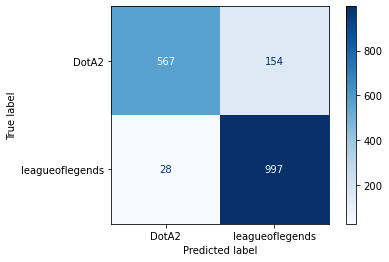

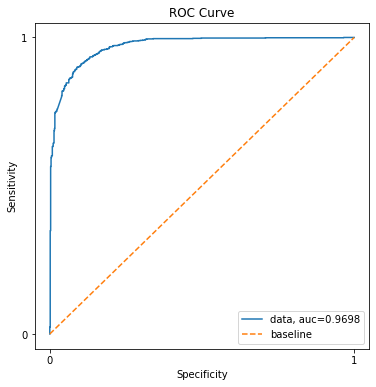

In [36]:
pipe2 = Pipeline([('tvec', TfidfVectorizer()),('lr', LogisticRegression())])

#Setting Pipe Parameters
pp2 = { 'tvec__max_features': [3_000, 4_000],
        'tvec__stop_words': ['english'],
        'tvec__ngram_range': [(1,1), (2,2)],
        'lr__C': np.logspace(-2, 2, 50),
        'lr__solver': ['liblinear', 'lbfgs'],
        'lr__penalty': ['l1','l2'],
        'lr__random_state': [123]}

scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

#gridsearchcv
gs_tvec = GridSearchCV(pipe2, param_grid = pp2, cv=5, scoring=scoring, refit='AUC')

#results
gs_tvec.fit(X_train, y_train)
score_dict = analyse_model_performance(gs_tvec, X_train, y_train, X_test, y_test)
scores.append(score_dict)
score_dict['model'] ="TF-IDFVec + Logistic Regression"

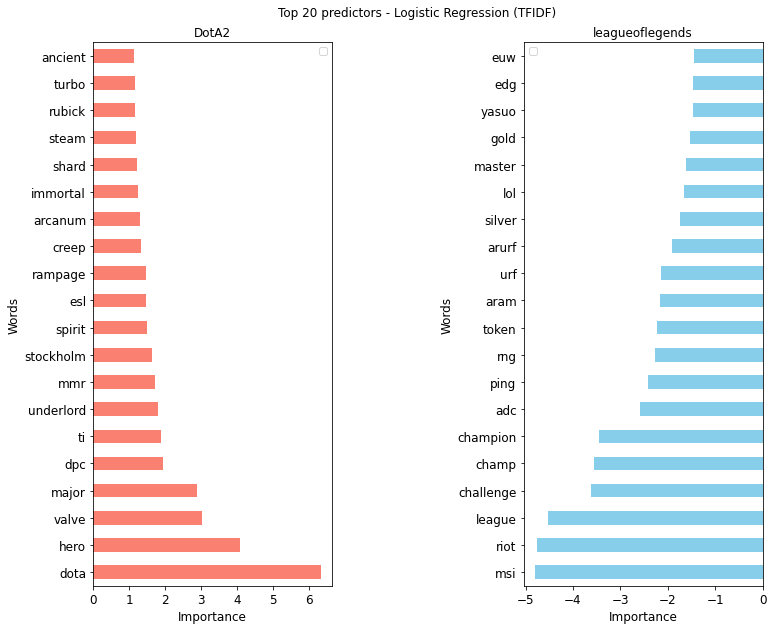

In [37]:
#Top 20 predictors
df_dota_cor, df_lol_cor = get_important_features_lr(gs_tvec.best_estimator_.named_steps.tvec, gs_tvec.best_estimator_.named_steps.lr, 20)
plot_important_words(df_lol_cor, df_dota_cor, title="Top 20 predictors - Logistic Regression (TFIDF)")

### Multinomial Naive Bayes (TFIDF)

optimal Parameters: 
{'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}

Cross Validation Score: 
0.9708128285224842

Train AUC Score: 
0.9950109272370619

Test AUC SCore: 
0.9705564764385508

Train Accuracy Score: 
0.9631630648330058

Test Accuracy Score: 
0.9083619702176403

Sensitivity: 
0.9473170731707317

Specificity: 
0.8529819694868238



<Figure size 648x648 with 0 Axes>

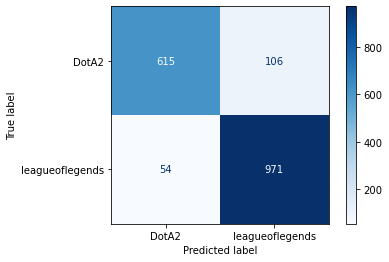

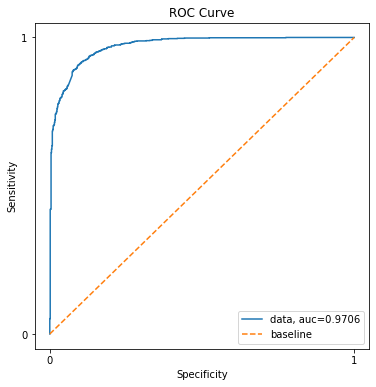

In [38]:
pipe3 = Pipeline([('tvec', TfidfVectorizer()),('nb', MultinomialNB())])

#Setting Pipe Parameters
pp3 = { 'tvec__max_features': [3_000, 4_000, 5_000],
        'tvec__stop_words': [None, 'english'],
        'tvec__ngram_range': [(1,1), (2,2)]}

scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

#gridsearchcv
gs_tvec3 = GridSearchCV(pipe3, param_grid = pp3, cv=5, scoring=scoring, refit='AUC')

#results
gs_tvec3.fit(X_train, y_train)
score_dict = analyse_model_performance(gs_tvec3, X_train, y_train, X_test, y_test)
scores.append(score_dict)
score_dict['model'] = "TF-IDFVec + Multinomial Naive Bayes"

### Multinomial Naive Bayes (Count Vector)

optimal Parameters: 
{'cvec__max_df': 0.8, 'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1)}

Cross Validation Score: 
0.9679729987829834

Train AUC Score: 
0.9861405525971059

Test AUC SCore: 
0.9698386387469977

Train Accuracy Score: 
0.9432711198428291

Test Accuracy Score: 
0.9020618556701031

Sensitivity: 
0.9034146341463415

Specificity: 
0.9001386962552012



<Figure size 648x648 with 0 Axes>

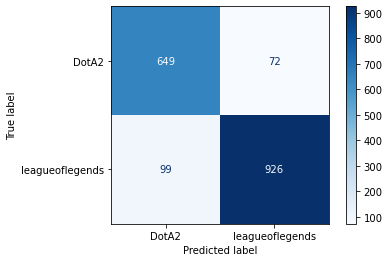

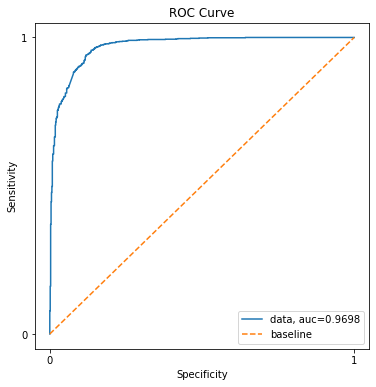

In [39]:
pipe4 = Pipeline([('cvec', CountVectorizer()),('nb', MultinomialNB())])

#Setting Pipe Parameters
pp4 = {'cvec__max_features': [2_000, 3_000, 4_000],
                    'cvec__min_df': [2,3],
                    'cvec__max_df': [0.8, 0.85, .9],
                    'cvec__ngram_range': [(1,1), (1,2)]}

scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

#gridsearchcv
gs_vec3 = GridSearchCV(pipe4, param_grid=pp4, cv=5, scoring=scoring, refit='AUC') 

#results
gs_vec3.fit(X_train, y_train)
score_dict = analyse_model_performance(gs_vec3, X_train, y_train, X_test, y_test)
scores.append(score_dict)
score_dict['model'] ="CountVec + Multinomial Naive Bayes"

### Random Forest Classifier (TFIDF)

optimal Parameters: 
{'rf__max_depth': None, 'rf__n_estimators': 200, 'rf__random_state': 123, 'tvec__max_features': 4000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}

Cross Validation Score: 
0.9498123036293524

Train AUC Score: 
0.9990747849807756

Test AUC SCore: 
0.9586651331145767

Train Accuracy Score: 
0.993860510805501

Test Accuracy Score: 
0.8991981672394044

Sensitivity: 
0.96

Specificity: 
0.812760055478502



<Figure size 648x648 with 0 Axes>

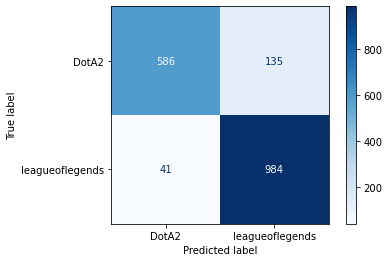

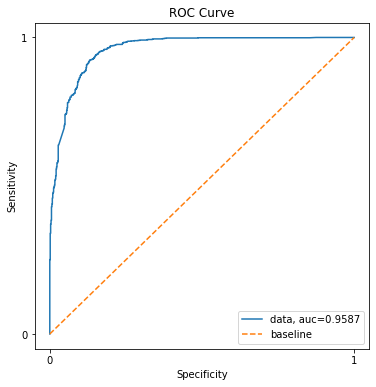

In [41]:
pipe5 = Pipeline([('tvec', TfidfVectorizer()),('rf', RandomForestClassifier())])

#Setting Pipe Parameters
pp5 = {'tvec__max_features': [4_000, 5_000],
                     'tvec__stop_words': ['english'],
                     'tvec__ngram_range': [(1,1), (1,2)],
                     'rf__n_estimators': [100, 150, 200],
                     'rf__max_depth': [None,4],
                     'rf__random_state': [123]}

scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

#gridsearchcv
gs_tvec2 = GridSearchCV(pipe5, param_grid = pp5, cv=5, scoring=scoring, refit='AUC') 

#results
gs_tvec2.fit(X_train, y_train)
score_dict = analyse_model_performance(gs_tvec2, X_train, y_train, X_test, y_test)
scores.append(score_dict)
score_dict['model'] ="TF-IDF Vec + random forest"

### Random Forest Classifier (TFIDF)

optimal Parameters: 
{'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'rf__max_depth': None, 'rf__n_estimators': 250, 'rf__random_state': 123}

Cross Validation Score: 
0.9471851842321909

Train AUC Score: 
0.998788018067559

Test AUC SCore: 
0.9542951862250939

Train Accuracy Score: 
0.994351669941061

Test Accuracy Score: 
0.8951890034364262

Sensitivity: 
0.9326829268292683

Specificity: 
0.841886269070735



<Figure size 648x648 with 0 Axes>

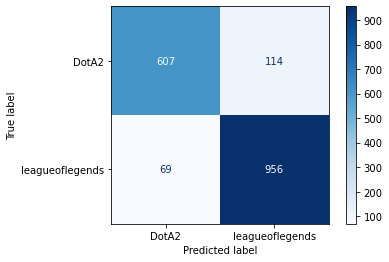

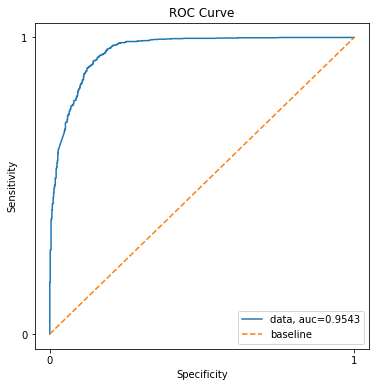

In [42]:
pipe6 = Pipeline([('cvec', CountVectorizer()),('rf', RandomForestClassifier())])

#Setting Pipe Parameters
pp6 = {'cvec__max_features': [3_000, 4_000],
                    'cvec__min_df': [2, 3],
                    'cvec__max_df': [.9, .85],
                    'cvec__ngram_range': [(1,1), (1,2)],
                    'rf__n_estimators': [150, 200, 250],
                    'rf__max_depth': [None,4],
                    'rf__random_state': [123]}

scoring={'AUC': 'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

#gridsearchcv
gs_vec2 = GridSearchCV(pipe6, param_grid = pp6, cv=5, scoring=scoring, refit='AUC') 

#results
gs_vec2.fit(X_train, y_train)
score_dict = analyse_model_performance(gs_vec2, X_train, y_train, X_test, y_test)
scores.append(score_dict)
score_dict['model'] ="CountVec + Random Forests"

In [43]:
df_scores = pd.DataFrame(scores)
df_scores = df_scores.sort_values(by='test_accuracy_score', ascending=False)
df_scores = df_scores.reset_index(drop=True)
df_scores

,model,cross_val_score,train_auc_score,test_auc_score,train_accuracy_score,test_accuracy_score,sensitivity,specificity
0,TF-IDFVec + Multinomial Naive Bayes,0.970813,0.995011,0.970556,0.963163,0.908362,0.947317,0.852982
1,CountVec + Multinomial Naive Bayes,0.967973,0.986141,0.969839,0.943271,0.902062,0.903415,0.900139
2,TF-IDF Vec + random forest,0.949812,0.999075,0.958665,0.993861,0.899198,0.960000,0.812760
3,TF-IDFVec + Logistic Regression,0.967175,0.994350,0.969788,0.946709,0.895762,0.972683,0.786408
4,CountVec + Random Forests,0.947185,0.998788,0.954295,0.994352,0.895189,0.932683,0.841886
5,CountVec + Logistic Regression,0.956559,0.992004,0.965459,0.916749,0.870561,0.976585,0.719834


## Conclusions and Recommendations

From the results above we can observe that Multinomial Naive Bayes in TF-IDF vector data gives the highest accuracy, and will hence be the model choosen for model testing and evaluation. With the model accuracy score of 90.%, it is also safe to assume that the model will be adequent at classifying posts and comments on Twitch's now single thread forum for VideoGames. The model will however be expect to be a little over-fitted when doing the actual test especially when we are doing classification outside of reddit, with data pulled from reddit. The following section on limitations and future works will detail how we can improve this model to further improve model accuracy and reduce model over-fitting.   

## Limitations and Future Works

1. As seen from the Train and test results from each models that the model is slightly overfitted. This is a result of insufficient removal of extra stopwords, and words that are not meaningful in classifying the respective video games comments. For e.g. the word Gold is one of the predictors of the model but it appears in both subreddits as both the in-game currency in Dota2 and LoL is refered to as Gold.
2. The analysis is only based on 3 models, other models like KNN might give better results.
3. Sub-threads from sources other than reddit can be used for a more holistic analysis for model building